In [1]:
'''Importing all necessary libraries'''

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split, ConcatDataset,SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.distributions.normal import Normal
import torch.optim as optim
import random
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.utils import make_grid
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import plotly.express as px

# **Part 1**

# **Dataset Preparation**

In [2]:
'''Importing the MNIST Dataest'''

transform = transforms.Compose([transforms.Pad(padding = 2),
                                transforms.ToTensor()
                               ])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.92MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Number of Images labeled 1:  6742
Number of Images labeled 2:  5958


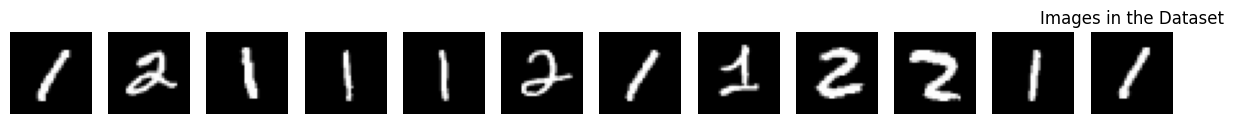

In [3]:
'''Due to limited computational budget, only using images labeled 1 and 2.
    Creating a new dataset, and plotting the images.'''

train_idx = [i for i, (img,label) in enumerate(train_dataset) if label in [1,2]]
test_idx = [i for i, (img,label) in enumerate(test_dataset) if label in [1,2]]

train_set = Subset(train_dataset, train_idx)
test_set = Subset(test_dataset, test_idx)

count = [0,0,0,0,0,0,0,0,0]
for img,label in train_set:
    count[label]+=1

print("Number of Images labeled 1: ",count[1])
print("Number of Images labeled 2: ",count[2])

fig, axes = plt.subplots(1, 12, figsize=(15, 2))
plt.title("Images in the Dataset")
for i in range(12):
    axes[i].imshow(train_set[i][0].squeeze(), cmap = 'gray')
    axes[i].axis('off')
plt.show()

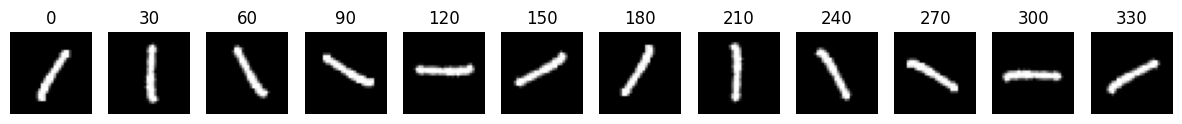

Number of images in train dataest =  10160
Number of images in validation dataset =  2540


In [4]:
'''Rotating each image in steps of 30 degrees. Thus creating a new train and test dataset.
    Plotting an image labeled 1 in steps of 30 degrees.'''

angles = [0,30,60,90,120,150,180,210,240,270,300,330]

rotated_train_data_imgs = {theta: [] for theta in angles}
rotated_train_data_labels = []
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

for img,label in train_set:
    img_pil = to_pil(img)
    for theta in angles:
        temp_img = img_pil.rotate(theta,resample = Image.BICUBIC)
        rotated_train_data_imgs[theta].append(to_tensor(temp_img))
    rotated_train_data_labels.append(label)

rotated_test_data_imgs = {theta: [] for theta in angles}
rotated_test_data_labels = []

for img,label in test_set:
    img_pil = to_pil(img)
    for theta in angles:
        temp_img = img_pil.rotate(theta, resample = Image.BICUBIC)
        rotated_test_data_imgs[theta].append(to_tensor(temp_img))
    rotated_test_data_labels.append(label)

rotated_train_data_imgs = {theta: torch.stack(rotated_train_data_imgs[theta]) for theta in angles}
rotated_test_data_imgs = {theta: torch.stack(rotated_test_data_imgs[theta]) for theta in angles}

rotated_train_data_labels = torch.tensor(rotated_train_data_labels)
rotated_test_data_labels = torch.tensor(rotated_test_data_labels)


rot_train_dataset = {theta:
                     TensorDataset(rotated_train_data_imgs[theta],
                                   rotated_train_data_labels)
                     for theta in angles}

rot_test_dataset = {theta:
                     TensorDataset(rotated_test_data_imgs[theta],
                                   rotated_test_data_labels)
                     for theta in angles}


fig, axes = plt.subplots(1, 12, figsize=(15, 2))
for i in range(12):
    axes[i].imshow(rotated_train_data_imgs[i*30][0].squeeze(), cmap = 'gray')
    axes[i].axis('off')
    axes[i].set_title(f"{i*30}")
# plt.title("Rotation of a sample image in steps of 30 degrees")
plt.show()


'''Splitting the train dataset into training and validation dataset.'''

train_ratio = 0.8
val_ratio = 1 - train_ratio

num_train = int(len(rot_train_dataset[0]) * train_ratio)
num_val = len(rot_train_dataset[0]) - num_train
val_idx = random.sample(range(len(rot_train_dataset[0])), num_val)
train_idx = list(set(range(len(rot_train_dataset[0])))-set(val_idx))

rotated_train_dataset={theta: Subset(rot_train_dataset[theta], train_idx) for theta in angles}
rotated_val_dataset={theta: Subset(rot_train_dataset[theta], val_idx) for theta in angles}

print("Number of images in train dataest = ",len(rotated_train_dataset[0]))
print("Number of images in validation dataset = ",len(rotated_val_dataset[0]))

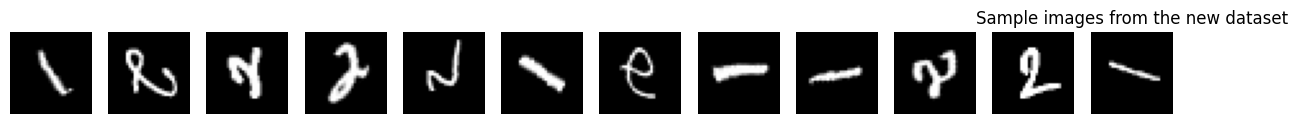

In [5]:
'''Combining all the datasets corresposding to individual rotation angles.'''

def combine_all_rotations(rot_dataset, shuffle):
    all_data = []
    for theta in angles:
        all_data.extend(list(rot_dataset[theta]))
    if shuffle:
        random.shuffle(all_data)
    data_tensors = torch.stack([x[0] for x in all_data])
    label_tensors = torch.tensor([x[1] for x in all_data])
    combined_dataset = TensorDataset(data_tensors, label_tensors)
    combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=shuffle)
    return combined_dataloader


batch_size = 64

train_loader = combine_all_rotations(rotated_train_dataset, True)
val_loader = combine_all_rotations(rotated_val_dataset, False)
test_loader = combine_all_rotations(rot_test_dataset, False)

fig, axes = plt.subplots(1, 12, figsize=(15, 2))
for i in range(12):
    image, _= train_loader.dataset[i]
    axes[i].imshow(image.squeeze(), cmap = 'gray')
    axes[i].axis('off')
plt.title("Sample images from the new dataset")
plt.show()

# **Latent Space Creation**

In [6]:
'''Defining all the classes and functions necessary for VAE training.'''

device = ('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.0001
patience = 3
img_size= 32
channels = 1
embedding_dim = 16
epochs = 70
shape_before_flattening = (64,16,16)


output_dir='output'
os.makedirs('output', exist_ok = True)

training_dir=os.path.join(output_dir, 'training')
os.makedirs(training_dir, exist_ok = True)

weights_dir = os.path.join(output_dir, 'weights')
os.makedirs(weights_dir, exist_ok = True)
model_path = os.path.join(weights_dir, 'vae.pt')


def kl_loss(m, logvar):
    kld = -0.5*torch.sum(1+logvar - m.pow(2) - logvar.exp(), dim=1)
    return kld.mean()
    

def bce_loss(x_hat, x):
    return 1000*nn.BCELoss()(x_hat, x)
    

def vae_loss(y_pred, y_true):
    m, logvar, x_hat = y_pred
    return bce_loss(x_hat, y_true)+kl_loss(m, logvar)
    
    

class sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch, dim = z_mean.shape
        epsilon = Normal(0,1).sample((batch,dim)).to(z_mean.device)
        return z_mean+torch.exp(0.5*z_log_var)*epsilon
        

class Encoder(nn.Module):
    def __init__(self, img_size, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,
                              out_channels = 32,
                              kernel_size = 3,
                              stride = 2,
                              padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32,
                              out_channels = 64,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64,
                              out_channels = 64,
                              kernel_size = 3,
                              stride = 1,
                              padding = 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*16*16, 1024)
        self.fc_mean = nn.Linear(1024, embedding_dim)
        self.fc_logvar = nn.Linear(1024, embedding_dim)
        self.sampling = sampling()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x=F.relu(self.bn3(self.conv3(x)))
        x= self.flatten(x)
        x=self.fc1(x)
        z_mean = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        z=self.sampling(z_mean, z_logvar)
        return z_mean, z_logvar, z


class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 1024)
        self.fc2 = nn.Linear(1024,
                        shape_before_flattening[0]
                        *shape_before_flattening[1]
                        *shape_before_flattening[2])
        self.reshape = lambda x:x.view(-1, *shape_before_flattening)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 64,
                                         out_channels = 64,
                                           kernel_size = 3,
                                         stride = 1,
                                         padding = 1,
                                         output_padding = 0)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 64,
                                         out_channels = 32,
                                         kernel_size = 3,
                                         stride = 1,
                                         padding = 1,
                                         output_padding = 0)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 32,
                                         out_channels = 1,
                   kernel_size = 3,
                                         stride = 2,
                                         padding = 1,
                                         output_padding = 1)

    def forward(self, x):
        x = self.fc1(x)
        x= self.fc2(x)
        x = self.reshape(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x


class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder= encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_logvar, z = self.encoder(x)
        x_cap = self.decoder(z)
        return z_mean, z_logvar, x_cap


def validate(encoder, decoder, test_loader):
    encoder.eval()
    decoder.eval()
    r_loss_kl, r_loss_bce, r_loss_total = 0.0, 0.0,0.0
    num_batches = len(test_loader)
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            encoded = encoder(data)
            decoded = decoder(encoded[2])
            loss_kl, loss_bce = kl_loss(encoded[0], encoded[1]) , bce_loss(decoded, data)
            r_loss_kl+=loss_kl
            r_loss_bce+=loss_bce
            r_loss_total += loss_kl+ loss_bce
    return (r_loss_kl/num_batches, r_loss_bce/num_batches, r_loss_total/num_batches)


In [7]:
'''Training.'''

encoder = Encoder(img_size, embedding_dim).to(device)
decoder = Decoder(embedding_dim, shape_before_flattening).to(device)
vae = VAE(encoder, decoder).to(device)

optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()),
                        lr,
                        weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                mode = "min",
                                                factor = 0.5,
                                                patience = patience)

best_val_loss = float("inf")
encoder.train()
decoder.train()


for epoch in range(epochs):
    train_loss = 0.0
    val_loss_kl, val_loss_bce, val_loss_total = 0.0,0.0,0.0
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        pred = vae(data)
        loss = vae_loss(pred, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss += running_loss/len(train_loader)
    val_loss = validate(encoder, decoder, val_loader)
    val_loss_kl+=val_loss[0]
    val_loss_bce+=val_loss[1]
    val_loss_total += val_loss[2]
    print(f"epoch: {epoch} train loss = {train_loss:.4f} val loss kl = {val_loss_kl:.4f} valloss bce = {val_loss_bce:.4f} val loss total= {val_loss_total:.4f}")
    if(val_loss_total<best_val_loss):
        best_val_loss = val_loss_total
        torch.save({"vae":vae.state_dict()}, model_path)

    scheduler.step(val_loss_total)

epoch: 0 train loss = 116.1134 val loss kl = 21.7237 valloss bce = 77.5487 val loss total= 99.2724
epoch: 1 train loss = 96.1418 val loss kl = 21.3747 valloss bce = 72.3218 val loss total= 93.6965
epoch: 2 train loss = 93.2484 val loss kl = 21.8136 valloss bce = 70.0885 val loss total= 91.9020
epoch: 3 train loss = 91.5650 val loss kl = 20.7411 valloss bce = 69.9045 val loss total= 90.6456
epoch: 4 train loss = 90.2980 val loss kl = 21.9437 valloss bce = 67.6679 val loss total= 89.6116
epoch: 5 train loss = 89.3986 val loss kl = 20.6957 valloss bce = 68.1720 val loss total= 88.8678
epoch: 6 train loss = 88.6298 val loss kl = 20.6144 valloss bce = 67.7189 val loss total= 88.3333
epoch: 7 train loss = 88.1106 val loss kl = 20.6480 valloss bce = 67.1165 val loss total= 87.7645
epoch: 8 train loss = 87.6243 val loss kl = 20.3612 valloss bce = 66.9033 val loss total= 87.2645
epoch: 9 train loss = 87.2407 val loss kl = 20.8734 valloss bce = 66.1236 val loss total= 86.9970
epoch: 10 train los

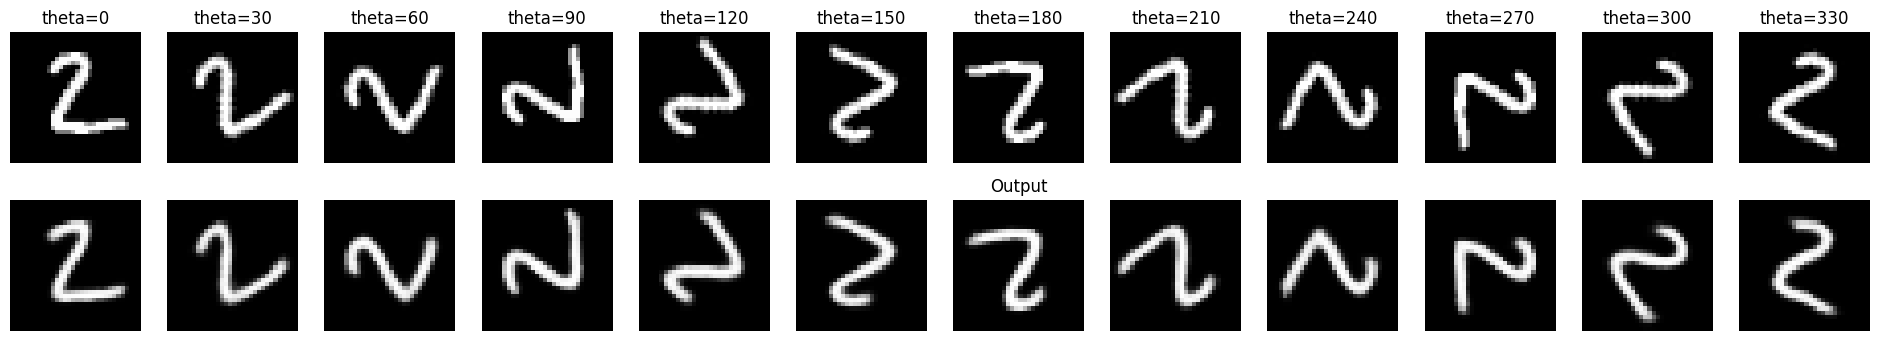

In [8]:
'''Visualizing the output of the Encoder and Decoder training.
    The top row is the input. It goes into the encoder and then the decoder.
    The ouput by the decoder is plotted in the bottom row.'''

vae.eval()
fig, axes = plt.subplots(2, len(angles), figsize=(len(angles)*2, 4))

model = vae

for i, theta in enumerate(angles):
    input_tensor, _= rot_test_dataset[theta][0]
    input_tensor = input_tensor.to(device)
    # print(input_tensor.shape)
    with torch.no_grad():
        zm, zlogvar, zpred = model.encoder(input_tensor.reshape(1, 1, 32, 32))
        ypred = model.decoder(zpred)

    axes[0,i].imshow(input_tensor.cpu().squeeze(), cmap='gray')
    axes[0,i].set_title(f"theta={theta}")
    axes[0,i].axis("off")

    axes[1,i].imshow(ypred.cpu().squeeze(), cmap='gray')
    axes[1,6].set_title(f"Output")
    axes[1,i].axis("off")

plt.show()

In [50]:
'''Latent Space Visualization.
    This plot only visualizes inputs with label 1 and 2.'''

latent_vectors = []
labels = []

for theta in angles:
    for batch_idx, (data, label) in enumerate(rot_test_dataset[theta]):
        if(batch_idx> 800):
            break
        label = label.item()
        data = data.to(device)
        with torch.no_grad():
            _, _, lvec = vae.encoder(data.reshape(1,1,32,32))
            latent_vectors.append(lvec.cpu().numpy())
            labels.append(label)

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.array(labels)

tsne = TSNE(n_components=2,perplexity = 30,n_iter=1000,random_state=56)
X_tsne = tsne.fit_transform(latent_vectors)

labels_category = pd.Categorical(labels)
fig = px.scatter(x=X_tsne[:, 0],y=X_tsne[:, 1], color=labels_category)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title = "visualization of latent space",
                 coloraxis_showscale=False,
                 width = 900,
                 height = 600)
fig.show()

In [49]:
'''Latent Space Visualizaion.
    This plot visualizes the rotation angles regardless of the image label.'''

latent_vectors = []
labels = []

for theta in angles:
    for batch_idx, (data, label) in enumerate(rot_test_dataset[theta]):
        if(batch_idx>800):
            break
        label = (label.item(), theta)
        data = data.to(device)
        with torch.no_grad():
            _, _, lvec = vae.encoder(data.reshape(1,1,32,32))
            latent_vectors.append(lvec.cpu().numpy())
            labels.append(label)

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.array(labels)
label_strings = [f"{theta}" for num,theta in labels]

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_strings)

reducer =TSNE(n_components=2,learning_rate=200, n_iter=1000,random_state=56)
X_tsne = reducer.fit_transform(latent_vectors)

fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=encoded_labels*30)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title="Visualization of latent vectors with respect to rotation degrees",
                  width=900,
                  height=600)
fig.show()

# **Part 2**

# **Supervised Symmetry Discovery**

training set generated
validation set generated
testing set generated


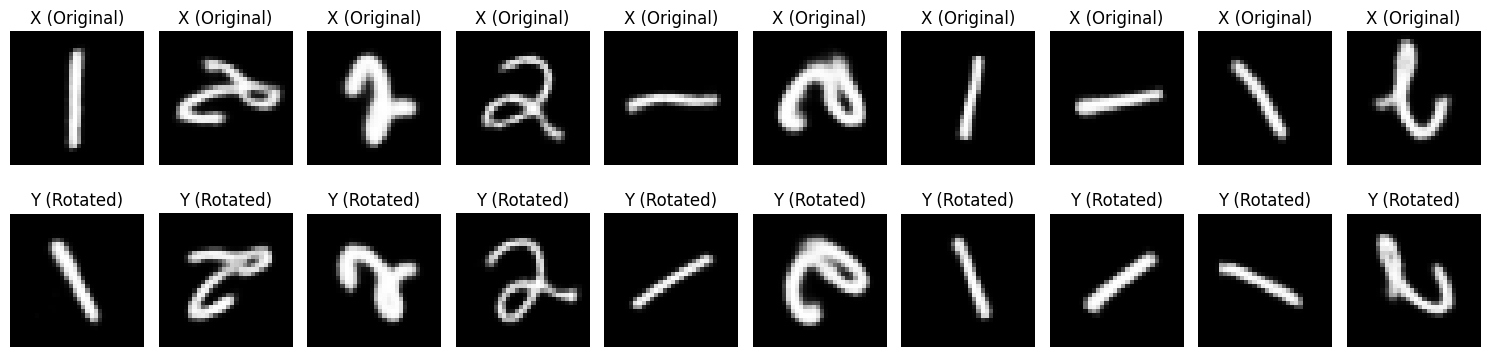

In [11]:
'''As we want to learn latent vector rotation by 30 degrees, we will need to create a new dataset.
    In the new dataset, each latent vector of an image is paired with a latent vector 
    which was generated by encoding the 30 degree rotated version of the original image.
    This way, each l.vector has a target of its 30 degree rotated version l.vector.
    We can see the plot to understand the dataset better.'''

def generate_new_loader(loader_dict, shuffle):
    X, y, y_temp = [], [], []
    count = 0
    len_of_data = len(loader_dict[0])
    num_samples = int(0.5*len_of_data)
    idx = random.sample(range(len_of_data), num_samples)
    for theta, loader in loader_dict.items():
        subset = Subset(loader, idx)
        new_loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
        for data in new_loader:
            inputs, _ = data
            inputs = inputs.to(next(vae.parameters()).device)
            _, _, vec = vae.encoder(inputs)
            if(inputs.shape[0]!=64):
                continue
            if(theta==0): count+=1
            X.append(vec.cpu().detach().numpy())
    X_new =[]
    for vec_x in X:
        tensor_vec_x = torch.Tensor(vec_x)
        X_new.append(tensor_vec_x)
    y_new = X_new[count:]+ X_new[:count]
    X_tensor = torch.cat(tuple(X_new), dim=0)
    y_tensor = torch.cat(tuple(y_new), dim=0)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


new_train_loader = generate_new_loader(rotated_train_dataset, True)
print("training set generated")
new_val_loader = generate_new_loader(rotated_val_dataset, True)
print("validation set generated")
new_test_loader = generate_new_loader(rot_test_dataset, False)
print("testing set generated")

X_sample, y_sample = next(iter(new_train_loader))
X_sample, y_sample = X_sample[:10], y_sample[:10]
X_sample = X_sample.to(device)
y_sample = y_sample.to(device)
X_decoded = vae.decoder(X_sample).cpu().detach().numpy()
y_decoded = vae.decoder(y_sample).cpu().detach().numpy()

fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    axes[0, i].imshow(X_decoded[i].squeeze(), cmap="gray")
    axes[0, i].set_title("X (Original)")
    axes[0, i].axis("off")

    axes[1, i].imshow(y_decoded[i].squeeze(), cmap="gray")
    axes[1, i].set_title("Y (Rotated)")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [12]:
'''Defining all the classes and functions required for MLP training.'''


lr_mlp = 0.01
patience_mlp = 3
epochs_mlp =75
mlp_model_path = os.path.join(weights_dir, 'mlp.pt')


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, 64, bias = True)
        self.do1 = nn.Dropout(0.3)
        self.bc1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        self. fc2 = nn.Linear(64, 128, bias = True)
        self.do2 = nn.Dropout(0.3)
        self.bc2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(128, 64, bias = True)
        self.do3 = nn.Dropout(0.3)
        self.bc3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(64, embedding_dim, bias = True)

        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.relu1(self.bc1(self.do1(self.fc1(x))))
        x = self.relu2(self.bc2(self.do2(self.fc2(x))))
        x = self.relu3(self.bc3(self.do3(self.fc3(x))))
        x = self.fc4(x)
        return x


def mse_loss(x_hat, x):
    return 50*nn.MSELoss()(x_hat, x)


def evaluate(model, test_loader):
    model.eval()
    loss= 0.0
    num_batches = len(test_loader)
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.to(device)
            label = label.to(device) 
            predicted = model(data)
            loss += mse_loss(predicted, label)
    return (loss/num_batches)

In [13]:
'''Training.'''


mlp = MLP().to(device)

optimizer = optim.AdamW(mlp.parameters(),
                        lr_mlp,
                        weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                mode = "min",
                                                factor = 0.5,
                                                patience = patience_mlp)

best_val_loss = float("inf")
mlp.train()
mlp = torch.nn.DataParallel(mlp)

for epoch in range(epochs_mlp):
    train_loss = 0.0
    val_loss = 0.0
    running_loss = 0.0
    for batch_idx, (data, label) in enumerate(new_train_loader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        pred = mlp(data)
        loss = mse_loss(pred, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
    train_loss += running_loss/len(new_train_loader)
    val_loss += evaluate(mlp, new_val_loader)
    print(f"epoch: {epoch} train loss = {train_loss:.4f} val loss= {val_loss:.4f}")
    if(val_loss<best_val_loss):
        best_val_loss = val_loss
        torch.save({"mlp":mlp.module.state_dict()}, mlp_model_path)

    scheduler.step(val_loss)

epoch: 0 train loss = 29.9880 val loss= 19.8742
epoch: 1 train loss = 17.4720 val loss= 16.8214
epoch: 2 train loss = 16.6675 val loss= 16.4569
epoch: 3 train loss = 16.4124 val loss= 16.3449
epoch: 4 train loss = 16.2353 val loss= 16.1315
epoch: 5 train loss = 16.1297 val loss= 16.2831
epoch: 6 train loss = 16.0605 val loss= 16.0285
epoch: 7 train loss = 15.9836 val loss= 16.1668
epoch: 8 train loss = 15.9377 val loss= 16.1064
epoch: 9 train loss = 15.8849 val loss= 15.9842
epoch: 10 train loss = 15.8532 val loss= 16.0052
epoch: 11 train loss = 15.8192 val loss= 15.9797
epoch: 12 train loss = 15.7824 val loss= 15.9199
epoch: 13 train loss = 15.7567 val loss= 16.0286
epoch: 14 train loss = 15.7165 val loss= 15.9921
epoch: 15 train loss = 15.7135 val loss= 15.8397
epoch: 16 train loss = 15.6917 val loss= 15.9900
epoch: 17 train loss = 15.6751 val loss= 15.9626
epoch: 18 train loss = 15.6568 val loss= 15.7513
epoch: 19 train loss = 15.6397 val loss= 15.8528
epoch: 20 train loss = 15.6259

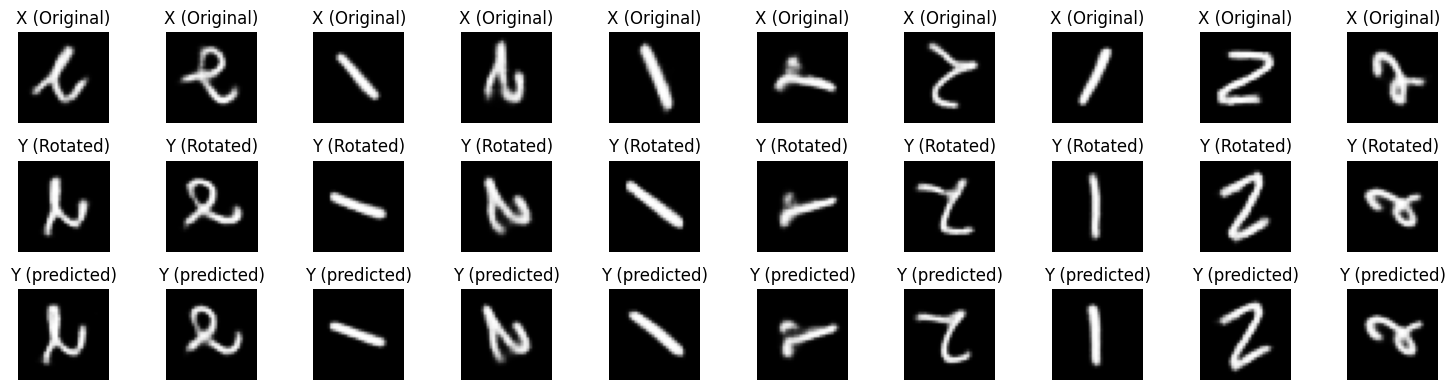

In [14]:
'''Visualization of the result of the trained MLP.
    The original image, the rotated image, and the output of the MLP by feeding in the original image are all plotted.'''

test_data = list(new_test_loader.dataset)

idx = random.sample(range(len(test_data)), 10)
X_sample, y_sample = zip(*[test_data[i] for i in idx])

X_sample = torch.stack(X_sample).to(device)
y_sample = torch.stack(y_sample).to(device)

X_decoded = vae.decoder(X_sample).cpu().detach().numpy()
y_decoded = vae.decoder(y_sample).cpu().detach().numpy()
y_predicted = vae.decoder(mlp(X_sample)).cpu().detach().numpy()

fig, axes = plt.subplots(3, 10, figsize=(15, 4))

for i in range(10):
    axes[0, i].imshow(X_decoded[i].squeeze(), cmap="gray")
    axes[0, i].set_title("X (Original)")
    axes[0, i].axis("off")

    axes[1, i].imshow(y_decoded[i].squeeze(), cmap="gray")
    axes[1, i].set_title("Y (Rotated)")
    axes[1, i].axis("off")

    axes[2,i].imshow(y_predicted[i].squeeze(), cmap = "gray")
    axes[2,i].set_title("Y (predicted)")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()


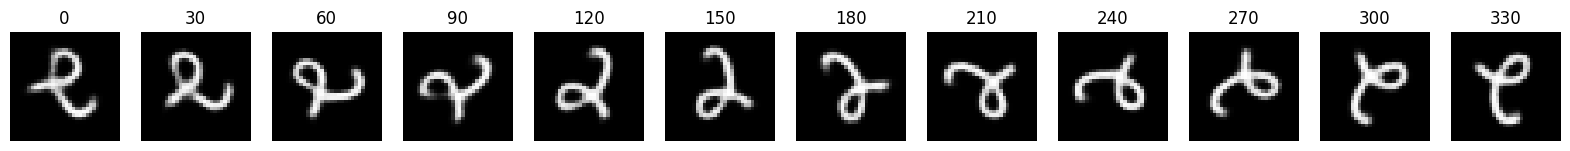

In [15]:
'''If we apply the MLP on an image 12 times, we can achieve a full rotation. 
    This is a demonstration of the idea.'''


complete_rotation = []
l_vec = X_sample[1]
complete_rotation.append(vae.decoder(l_vec).cpu().detach().numpy())

for i in range(12):
    l_vec = mlp(l_vec.reshape(1,-1))
    complete_rotation.append(vae.decoder(l_vec).cpu().detach().numpy())

fig, axes = plt.subplots(1, 12, figsize=(20, 4))

for i in range(12):
    axes[i].imshow(complete_rotation[i].squeeze(), cmap="gray")
    axes[i].set_title(f"{30*i}")
    axes[i].axis("off")

plt.show()

# **PART 3**

# **Unsupervised Symmetry Discovery**

**Induced Oracle:**


training set generated
validation set generated
testing set generated


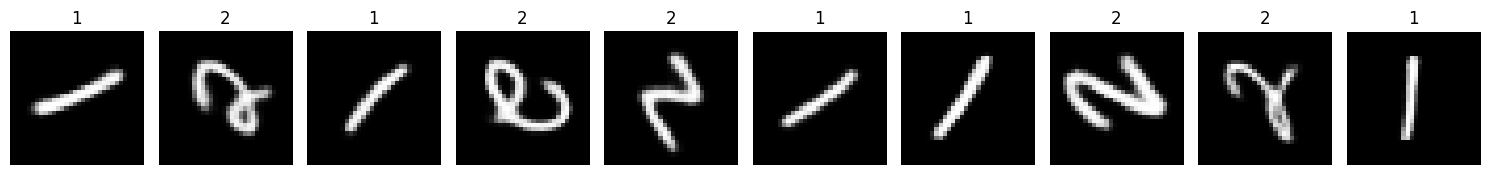

In [16]:
'''For training the Induced Oracle, we will need to create a new dataset.
    Each image(including all the rotated versions) are paired with their original label(i.e. 1 or 2).
    Visualizing the new dataset with the images and their corresponding labels.'''


def generate_symmetry_loader(loader, shuffle):
    X, y= [], []

    for tensor, label in loader:
        tensor = tensor.reshape(tensor.shape[0],1, 32, 32)
        tensor = tensor.to(device)
        label = label.to(device)
        _, _, vec = vae.encoder(tensor)
        if(tensor.shape[0]!=64):
            continue
        X.append(vec.cpu().detach().numpy())
        y.append(label)
    X_new =[]
    for vec_x in X:
        tensor_vec_x = torch.Tensor(vec_x)
        X_new.append(tensor_vec_x)

    X_tensor = torch.cat(tuple(X_new), dim=0)
    y_tensor = torch.cat(y, dim=0)

    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

sym_train_loader = generate_symmetry_loader(train_loader, True)
print("training set generated")
sym_val_loader = generate_symmetry_loader(val_loader, True)
print("validation set generated")
sym_test_loader = generate_symmetry_loader(test_loader, False)
print("testing set generated")

vae.eval()

X_sample, y_sample = next(iter(sym_train_loader))
X_sample, y_sample = X_sample[:10], y_sample[:10]

with torch.no_grad():
    X_sample = X_sample.to(device)
    X_decoded = vae.decoder(X_sample).cpu()

fig, axes = plt.subplots(1, 10, figsize=(15, 4))

for i in range(10):
    axes[i].imshow(X_decoded[i].squeeze(), cmap="gray")
    axes[i].set_title(f"{y_sample[i]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [17]:
'''Defining all the classes and functions required to train the Induced Oracle.'''


lr_oracle = 0.001
patience_oracle = 3
epochs_oracle = 10
oracle_model_path = os.path.join(weights_dir, 'oracle.pt')


class Oracle(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, 64, bias = True)
        self.do1 = nn.Dropout(0.5)
        self.bc1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        self. fc2 = nn.Linear(64, 128, bias = True)
        self.do2 = nn.Dropout(0.5)
        self.bc2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(128, 32, bias = True)
        self.do3 = nn.Dropout(0.5)
        self.bc3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(32, 2, bias = True)

        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.relu1(self.bc1(self.do1(self.fc1(x))))
        x = self.relu2(self.bc2(self.do2(self.fc2(x))))
        x = self.relu3(self.bc3(self.do3(self.fc3(x))))
        x = self.fc4(x)
        return x


def cross_entropy_loss(x_hat, x):
    x = x-1
    return 50* nn.CrossEntropyLoss()(x_hat, x)


def evaluate(model, test_loader):
    model.eval()
    loss= 0.0
    num_batches = len(test_loader)
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.to(device)
            predicted = model(data)
            loss += cross_entropy_loss(predicted, label)
    return (loss/num_batches)

In [18]:
'''Training.'''


oracle = Oracle().to(device)

optimizer = optim.AdamW(oracle.parameters(),
                        lr_oracle,
                        weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                mode = "min",
                                                factor = 0.5,
                                                patience = patience_oracle)

best_val_loss = float("inf")
oracle.train()
oracle = torch.nn.DataParallel(oracle)

for epoch in range(epochs_oracle):
    train_loss = 0.0
    val_loss = 0.0
    running_loss = 0.0
    for batch_idx, (data, label) in enumerate(sym_train_loader):
        data = data.to(device)
        label = label.to(device)
        if label.dim() > 1:
            label = torch.argmax(label, dim=1)

        label = label.long()
        optimizer.zero_grad()
        pred = oracle(data)
        loss = cross_entropy_loss(pred, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(oracle.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
    train_loss += running_loss/len(sym_train_loader)
    val_loss += evaluate(oracle, sym_val_loader)
    print(f"epoch: {epoch} train loss = {train_loss:.4f} val loss= {val_loss:.4f}")
    if(val_loss<best_val_loss):
        best_val_loss = val_loss
        torch.save({"oracle":oracle.module.state_dict()}, oracle_model_path)

    scheduler.step(val_loss)

epoch: 0 train loss = 7.8860 val loss= 1.9227
epoch: 1 train loss = 1.8218 val loss= 1.2789
epoch: 2 train loss = 1.4689 val loss= 1.1643
epoch: 3 train loss = 1.3215 val loss= 1.1063
epoch: 4 train loss = 1.1897 val loss= 1.1938
epoch: 5 train loss = 1.0788 val loss= 1.0845
epoch: 6 train loss = 1.0453 val loss= 1.2263
epoch: 7 train loss = 0.9473 val loss= 1.3585
epoch: 8 train loss = 0.8762 val loss= 1.3035
epoch: 9 train loss = 0.8495 val loss= 1.4080


In [19]:
'''Checking the accuracy on test dataset.'''

correct = 0
total = 0

for batch_idx, (data, label) in enumerate(sym_test_loader):
    pred_logit = oracle(data)
    pred = nn.Softmax(dim=1)(pred_logit)
    pred_labels = torch.argmax(pred, dim=1)
    label = label-1
    correct += (pred_labels == label).sum().item()
    total += label.shape[0]

accuracy_on_test = correct / total
print(f"Accuracy on test dataset: {100*accuracy_on_test:.4f}%")


Accuracy on test dataset: 99.6344%


# Finding symmetries:

In [35]:
'''Defining all the classes and functions required for training.
    The model used for the generators is the same as the one used in Supervised Symmetry Discovery.'''


class G_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, 64, bias = True)
        self.do1 = nn.Dropout(0.5)
        self.bc1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        self. fc2 = nn.Linear(64, 128, bias = True)
        self.do2 = nn.Dropout(0.5)
        self.bc2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(128, 64, bias = True)
        self.do3 = nn.Dropout(0.5)
        self.bc3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(64, embedding_dim, bias = True)

        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.relu1(self.bc1(self.do1(self.fc1(x))))
        x = self.relu2(self.bc2(self.do2(self.fc2(x))))
        x = self.relu3(self.bc3(self.do3(self.fc3(x))))
        x = self.fc4(x)
        return x


def loss_inf(oracle_model, sym_model, epsilon, input, label):
    oracle.eval()
    with torch.no_grad():
        pred = oracle(input + epsilon*sym_model(input))
        logit = oracle(input)
        loss = torch.mean((pred-logit)**2) / epsilon**2
    # print(f"loss_inf = {loss}")
    return loss

def loss_norm(sym_model, input):
    norm = torch.norm(sym_model(input), dim=1, keepdim=True)
    mu = torch.mean(norm)
    num = input.shape[0]
    norm_loss = torch.mean((norm-1)**2)
    norm_loss += torch.mean((norm-mu)**2)
    # print(f"norm_loss={norm_loss}")
    return norm_loss

def loss_ortho(sym_model_list, input):
    Ng = len(sym_model_list)
    total_loss = torch.tensor(0.0, device=input.device)
    for alpha in range(Ng):
        for beta in range(alpha + 1, Ng):
            g_alpha = sym_model_list[alpha]
            g_beta = sym_model_list[beta]
            dot_product = torch.einsum("bi,bi->b", g_alpha(input), g_beta(input))
            total_loss += torch.mean(dot_product**2)
    # print(f"loss_ortho = {total_loss*300}")
    return total_loss*300

'''Another possible approach to closure loss is to minimize the out-of-space components of the commutators with respect to the space of generators,
    after flattening and Gram–Schmidt orthonormalization.'''

def gram_schmidt(vectors):
    basis = []
    for v in vectors:
        w = v.clone()
        for b in basis:
            proj_scalar = torch.sum(w * b, dim=1, keepdim=True)
            w = w - proj_scalar * b
        norm = torch.norm(w, dim=1, keepdim=True)
        w = w / (norm + 1e-8)
        basis.append(w)
    return torch.stack(basis, dim=1)

def loss_closure(sym_model_list, data):
    Ng = len(sym_model_list)
    batch_size = data.shape[0]
    for model in sym_model_list:
        if next(model.parameters()).device != data.device:
            model.to(data.device)
    outputs = [sym_model(data).flatten(start_dim=1) for sym_model in sym_model_list]
    generators = torch.stack(outputs, dim=1)
    orthonormal_generators = gram_schmidt([generators[:, i, :] for i in range(Ng)])
    total_loss = torch.tensor(0.0, device=data.device)
    for alpha in range(Ng):
        for beta in range(alpha + 1, Ng):
            C_alpha_beta = sym_model_list[alpha](sym_model_list[beta](data)) - sym_model_list[beta](sym_model_list[alpha](data))
            C_flattened = C_alpha_beta.flatten(start_dim=1)
            projections = []
            for i in range(Ng):
                basis_vec = orthonormal_generators[:, i, :]
                proj = torch.sum(C_flattened * basis_vec, dim=1, keepdim=True) * basis_vec
                projections.append(proj)
            approx_C = sum(projections)
            error = torch.norm(C_flattened - approx_C, p=2)**2
            total_loss += error
    # print("closure_loss ",total_loss)
    return total_loss

def evaluate(test_loader, sym_model_list):
    model.eval()
    loss= 0.0
    num_batches = len(test_loader)
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.to(device)
            loss += sum(loss_inf(oracle, sym_model, epsilon, data, label) + loss_norm(sym_model, data) for sym_model in sym_model_list)
            loss +=  loss_closure(sym_model_list, data) + loss_ortho(sym_model_list, data)
    return (loss/num_batches)

In [42]:
'''Training
    Only training 1 generator model.
    I was unable to obtain satisfactory results while training more than 1 generator model.'''



lr_sym = 0.00003
Ng = 1
epochs_sym = 11
epsilon = 0.001

sym_model_path = [os.path.join(weights_dir, f'sym_model{i}.pt') for i in range(Ng)]
sym_model_list = [G_model().to(device) for _ in range(Ng)]
optimizers = [
    optim.Adam(sym_model_list[i].parameters(), lr=lr_sym, weight_decay=1e-5)
    for i in range(Ng)
]
schedulers = [
    optim.lr_scheduler.ReduceLROnPlateau(optimizers[i], mode="min", factor=0.5, patience=patience_oracle)
    for i in range(Ng)
]

oracle.to(device)
oracle.eval()
for param in oracle.parameters():
    param.requires_grad = False

[sym_model.train() for sym_model in sym_model_list]
best_val_loss = float("inf")

for epoch in range(epochs_sym):
    train_loss = 0.0
    running_loss = 0.0
    for batch_idx, (data, label) in enumerate(sym_train_loader):
        data = data.to(device)
        label = label.to(device).long()

        for i, sym_model in enumerate(sym_model_list):
            optimizers[i].zero_grad()
            loss = loss_inf(oracle, sym_model, epsilon, data, label) + loss_norm(sym_model, data)
            loss.backward()
            optimizers[i].step()
            running_loss += loss.item()

        if(Ng>1):
            for optimizer in optimizers:
                optimizer.zero_grad()
            loss_joint = loss_closure(sym_model_list, data) + loss_ortho(sym_model_list, data)
            loss_joint.backward()
            for optimizer in optimizers:
                optimizer.step()
            running_loss += loss_joint.item()
        
    train_loss = running_loss / len(sym_train_loader)
    val_loss = evaluate(sym_val_loader, sym_model_list)
    print(f"Epoch {epoch} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        for i, sym_model in enumerate(sym_model_list):
            torch.save({"model_state_dict": sym_model.state_dict()}, sym_model_path[i])
    
    for scheduler in schedulers:
        scheduler.step(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)


Epoch 0 Train Loss: 58.7272 Val Loss: 32.2490
Epoch 1 Train Loss: 24.7586 Val Loss: 20.3504
Epoch 2 Train Loss: 17.3095 Val Loss: 14.9750
Epoch 3 Train Loss: 12.6637 Val Loss: 10.9795
Epoch 4 Train Loss: 9.5604 Val Loss: 8.7722
Epoch 5 Train Loss: 8.1420 Val Loss: 7.6108
Epoch 6 Train Loss: 7.2858 Val Loss: 6.9603
Epoch 7 Train Loss: 6.4981 Val Loss: 6.3512
Epoch 8 Train Loss: 5.9172 Val Loss: 5.7803
Epoch 9 Train Loss: 5.3642 Val Loss: 5.1604
Epoch 10 Train Loss: 5.0005 Val Loss: 4.9476


In [44]:
'''Defining a function to clearly visualize the transformation by our generator model.
    The same method used in the paper has been implemented.
    The original image is situated in the centre and the transformations are applied to the left and right in steps of a few thousands.'''


def plot_the_result(its, Ng, sample_idx):
    X_sample, y_sample = next(iter(sym_test_loader))
    X_sample, y_sample = X_sample[sample_idx], y_sample[sample_idx]
    X_sample = X_sample.to(device)
    
    transformed_mat = []
    for sym_model in sym_model_list:
        sym_model.eval()
        trans_list = []
        X_sample_trans = X_sample.view(1, -1)
        trans_list.append(X_sample_trans)
        for iteration in range(its[-1]+1):
            X_sample_trans = X_sample_trans + epsilon*sym_model(X_sample_trans)
            if(iteration in its):
                trans_list.append(X_sample_trans)
        X_sample_trans = X_sample.view(1,-1)
        for iteration in range(its[-1]+1):
            X_sample_trans = X_sample_trans - epsilon*sym_model(X_sample_trans)
            if(iteration in its):
                trans_list.append(X_sample_trans)
        transformed_mat.append(trans_list)
    transformed_imgs = []
    for i in range(Ng):
        temp_list = []
        for j in range(7):
            img = vae.decoder(transformed_mat[i][j]).cpu().detach().numpy().squeeze()
            temp_list.append(img)
        transformed_imgs.append(temp_list)
    
    fig, axes = plt.subplots(Ng, 7, figsize=(10, 4))

    if(Ng==1):
        for i in range(Ng):
            img = transformed_imgs[i][0]
            axes[3].imshow(img, cmap="gray")
            axes[3].axis("off")
            for j in range(3):
                img = transformed_imgs[i][j+1]
                axes[j+4].imshow(img, cmap="gray")
                axes[j+4].axis("off")
            for j in range(3):
                img = transformed_imgs[i][j+4]
                axes[2-j].imshow(img, cmap="gray")
                axes[2-j].axis("off")
        
        plt.tight_layout()
        plt.show()

    elif(Ng>1):
        for i in range(Ng):
            img = transformed_imgs[i][0]
            axes[i][3].imshow(img, cmap="gray")
            axes[i][3].axis("off")
            for j in range(3):
                img = transformed_imgs[i][j+1]
                axes[i][j+4].imshow(img, cmap="gray")
                axes[i][j+4].axis("off")
            for j in range(3):
                img = transformed_imgs[i][j+4]
                axes[i][2-j].imshow(img, cmap="gray")
                axes[i][2-j].axis("off")
        
        plt.tight_layout()
        plt.show()

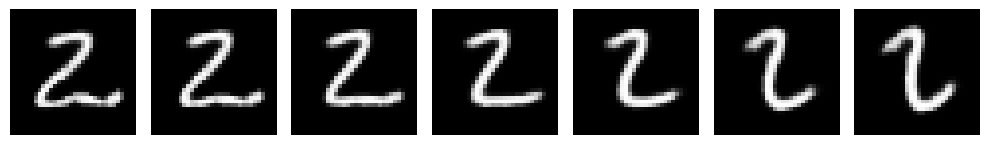

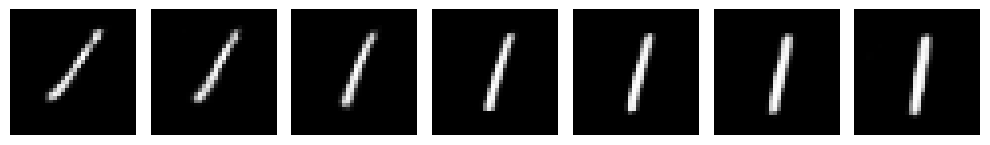

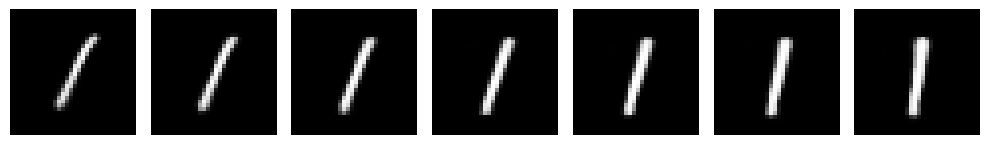

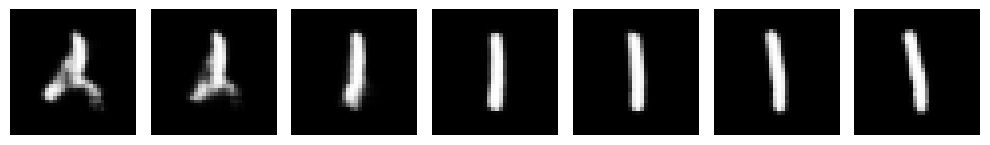

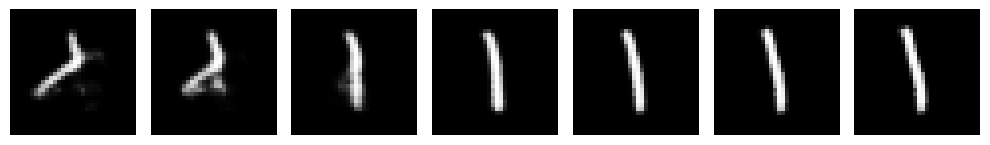

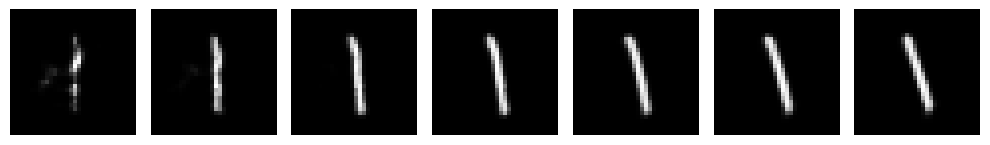

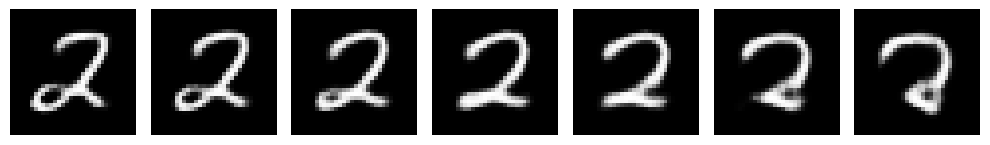

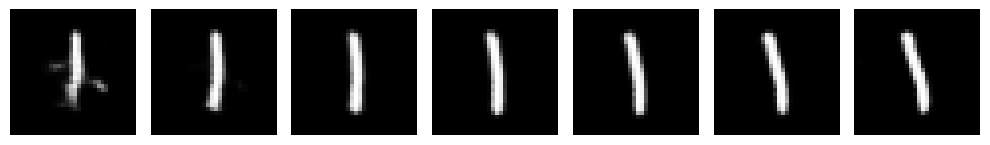

In [45]:
'''Plotting the transformation on 10 sample images from the test dataset in steps of 2000 iterations.
    We can see that some of the images are being rotated. But their rate of rotation could be improved.
    We can achieve this by increasing the steps from 2000 to 3000 or 4000.'''


for i in range(8):
    plot_the_result([2000,4000,6000],1,i)

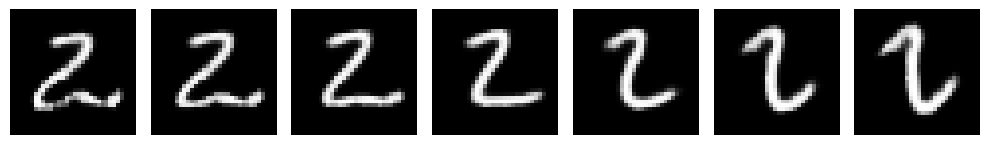

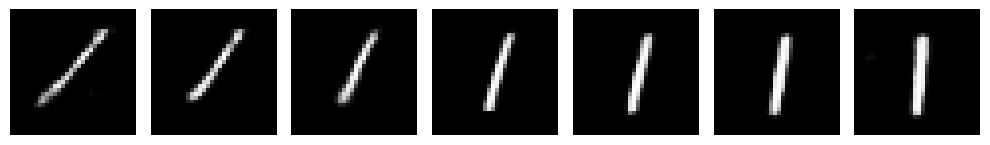

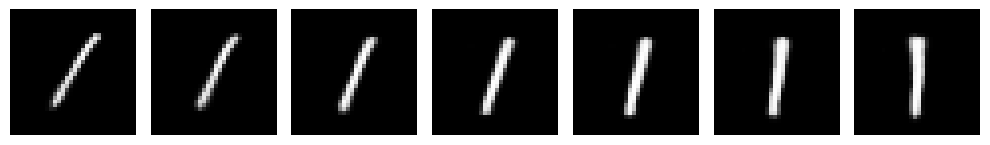

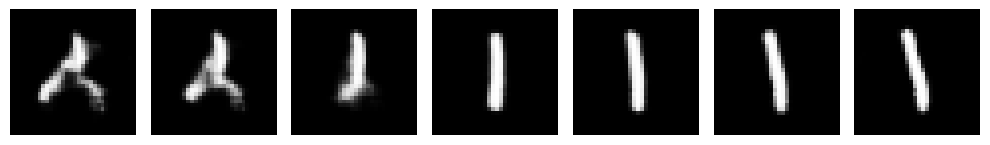

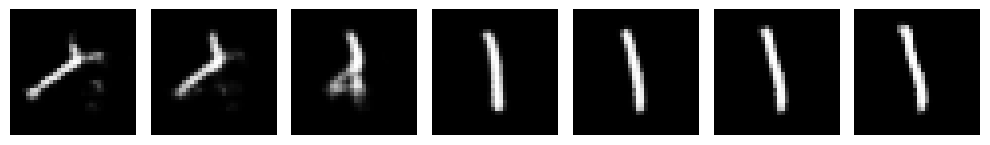

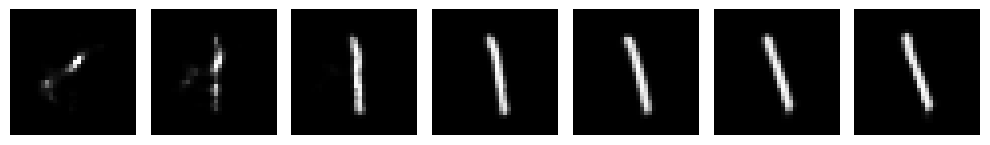

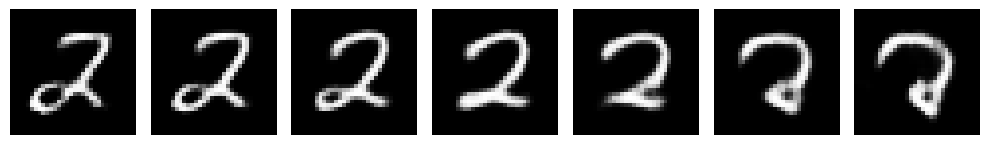

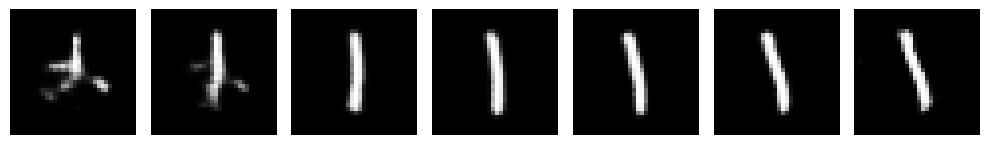

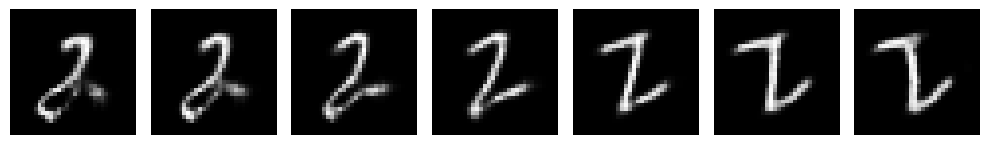

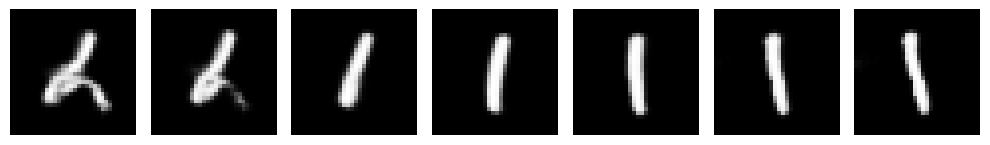

In [48]:
'''Plotting the transformations of the same images in steps of 3000'''

for i in range(10):
    plot_the_result([3000,6000,9000],1,i)

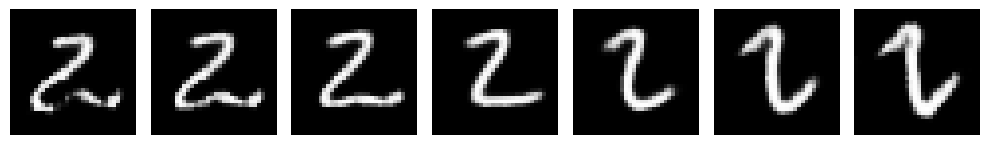

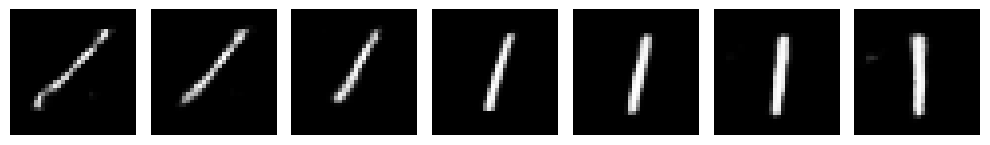

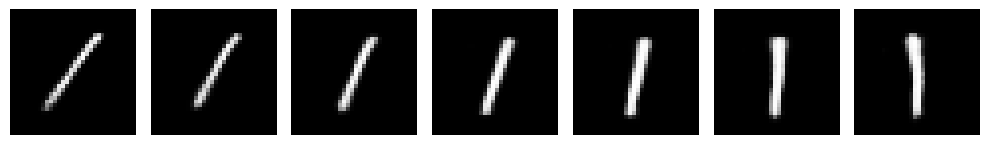

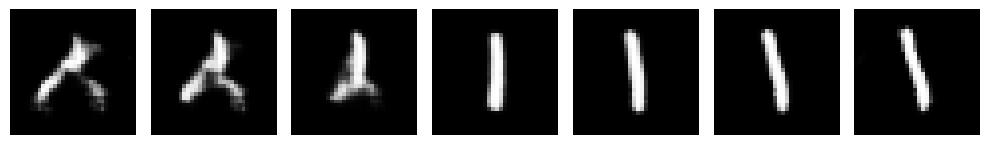

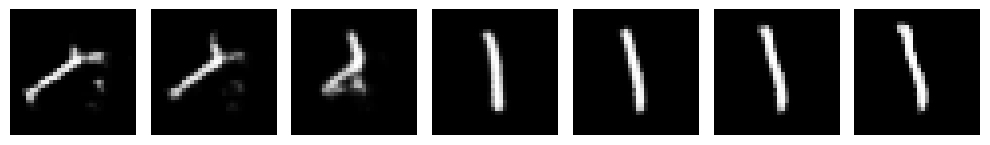

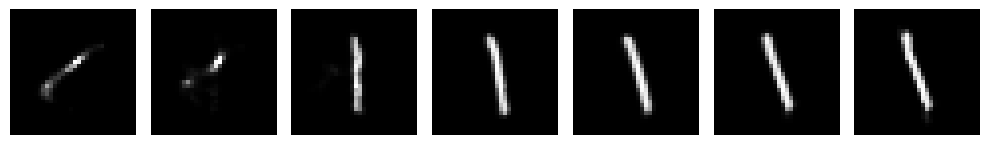

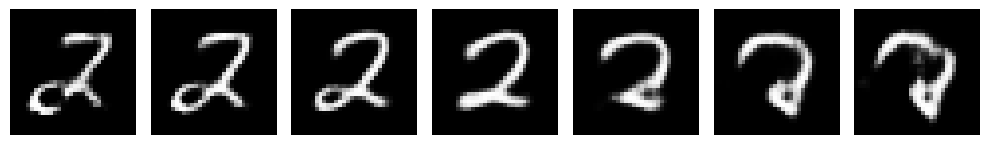

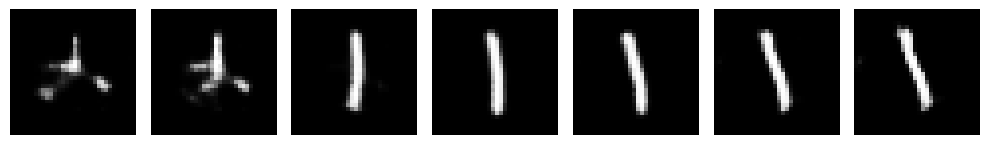

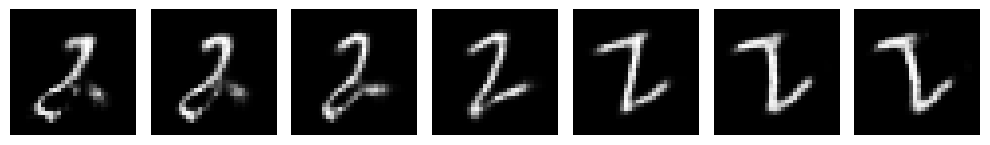

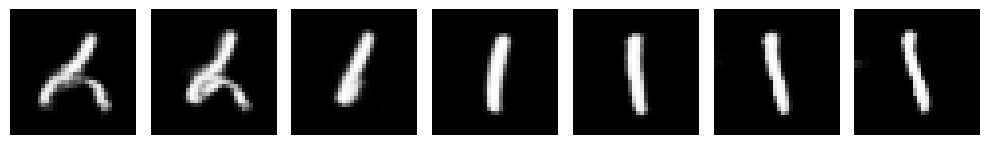

In [47]:
'''Plotting the transformations of images in steps of 4000.'''


for i in range(10):
    plot_the_result([4000,8000,12000],1,i)